# MT 미국달러 리서치 리포트

본 노트북은 아래 3단계를 통해 파라미터를 탐색하고, 최종 성과지표와 시각화를 도출합니다.

**Pipeline**
1) 베스트 인덱스 & 조정률 탐색  
2) 상승/하락 거래 필터 탐색  
3) 매수/매도 스탑로스 탐색 (정밀탐색 포함)

**성과지표**
- Headline Metrics: Total PnL, Trades, Win Rate, MDD, Calmar-like, Baseline 비교  
- 표준 성과 테이블: total_trades, total_pnl, avg_pnl_per_trade, win_rate, sharpe_annual(approx), mdd_abs, cagr_assuming_init1, period_days, period_years  
- 기간별 성과: 최근 5년, 최근 1년

**시각화**
- 에쿼티 커브 (최종/베이스라인)  
- 드로우다운 곡선

> 실행 순서: 위에서 아래로 각 셀을 차례대로 실행하세요. `FILE_NAME` 변수에 CSV 경로를 지정하면 됩니다.

In [1]:
# 0) 공통 유틸
import numpy as np
import pandas as pd
from decimal import Decimal, getcontext
from math import sqrt
import matplotlib.pyplot as plt
from IPython.display import display

pd.options.display.float_format = lambda x: f"{x:.6f}"
getcontext().prec = 18

FILE_NAME = "mt-usd0920-new.csv"  # 필요시 수정

def calculate_pct_change(df, col_name_current, col_name_previous):
    return (df[col_name_current] / df[col_name_previous].shift(1) - 1) * 100

def ceil_to_nearest(value, step):
    return np.ceil(value / step) * step

def gen_stops_decimal(stop_min='0.00050', stop_max='0.05000', step='0.00005'):
    """Decimal로 정확한 스텝 생성(0.395% 누락 방지)"""
    a = Decimal(stop_min); b = Decimal(stop_max); d = Decimal(step)
    x = a; eps = Decimal('1e-15')
    while x <= b + eps:
        yield float(x)
        x += d

def compute_drawdown_series(equity_series: pd.Series):
    roll_max = equity_series.cummax()
    dd_abs = equity_series - roll_max
    mdd_abs = dd_abs.min()
    return dd_abs, float(mdd_abs)

def compute_metrics_from_daily(df_daily: pd.DataFrame, init_equity: float = 1.0):
    s = df_daily["Total_PnL"].fillna(0.0).astype(float)
    long_rows = []
    for _, r in df_daily.iterrows():
        if r.get("Buy_Trade", False):
            long_rows.append(("buy", r.get("Buy_PnL", 0.0)))
        if r.get("Sell_Trade", False):
            long_rows.append(("sell", r.get("Sell_PnL", 0.0)))
    long = pd.DataFrame(long_rows, columns=["side", "pnl"]) if long_rows else pd.DataFrame(columns=["side","pnl"])
    total_trades = int(len(long))
    win_rate = float((long["pnl"] > 0).mean()) if total_trades > 0 else 0.0

    equity = init_equity + s.cumsum()
    dd_series, mdd_abs = compute_drawdown_series(equity)

    mu = float(s.mean())
    sig = float(s.std(ddof=1))
    sharpe_annual = (mu / sig * sqrt(252)) if sig > 0 else 0.0

    total_pnl = float(s.sum())
    avg_pnl_per_trade = total_pnl / total_trades if total_trades > 0 else 0.0

    days = int((df_daily["Date"].max() - df_daily["Date"].min()).days + 1)
    years = days / 365.25 if days > 0 else 0
    end_equity = float(equity.iloc[-1]) if len(equity) else init_equity
    cagr = (end_equity / init_equity) ** (1/years) - 1 if years > 0 and end_equity > 0 else -1.0
    calmar_like = (cagr / abs(mdd_abs)) if mdd_abs < 0 else np.inf

    return {
        "total_trades": total_trades,
        "total_pnl": total_pnl,
        "avg_pnl_per_trade": avg_pnl_per_trade,
        "win_rate": win_rate,
        "sharpe_annual(approx)": sharpe_annual,
        "mdd_abs": mdd_abs,
        "cagr_assuming_init1": cagr,
        "period_days": days,
        "period_years": years,
        "equity_series": equity,
        "dd_series": dd_series,
    }

def slice_by_years(df_daily: pd.DataFrame, years: int):
    end = df_daily["Date"].max()
    start = end - pd.DateOffset(years=years)
    return df_daily[df_daily["Date"] >= start].copy()

def plot_equity(equity: pd.Series, title="Equity Curve"):
    plt.figure(figsize=(10, 4))
    plt.plot(equity.index, equity.values)
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("Equity (init 1 + Cum PnL)")
    plt.grid(True)
    plt.show()

def plot_drawdown(dd: pd.Series, title="Drawdown (absolute)"):
    plt.figure(figsize=(10, 3))
    plt.plot(dd.index, dd.values)
    plt.title(title)
    plt.xlabel("Date"); plt.ylabel("DD (absolute)")
    plt.grid(True)
    plt.show()


In [3]:
# 필요한 경우 (노트북 상단에서 이미 했다면 중복 import 무방)
import numpy as np
import pandas as pd
from IPython.display import display

# 1) 베스트 인덱스 & 조정률 탐색
df = pd.read_csv(FILE_NAME, header=None)
df.columns = [
    "Date", "Open", "High", "Low", "Close",
    "Index1", "Index2", "Index3", "Index4", "Index5",
    "Index6", "Index7", "Index8", "Index9", "Index10", "Index11"
]
df["Date"] = pd.to_datetime(df["Date"]) 
df["Open_Pct_Change"] = calculate_pct_change(df, "Open", "Close")
for i in range(1, 12):
    df[f"Index{i}_Pct_Change"] = calculate_pct_change(df, f"Index{i}", f"Index{i}")

def find_optimal_adjustment_rate(index_col, open_pct_col, df,
                                 rate_min=0.000, rate_max=5.000, rate_step=0.005):
    data = df[[index_col, open_pct_col, "Open", "Close"]].dropna().copy()
    idx  = data[index_col].to_numpy(np.float64)
    opct = data[open_pct_col].to_numpy(np.float64)
    O = data["Open"].to_numpy(np.float64)
    C = data["Close"].to_numpy(np.float64)
    up = (idx > 0); down = (idx < 0)
    rates = np.arange(rate_min, rate_max, rate_step, dtype=np.float64)
    if rates.size == 0: 
        raise ValueError("empty rate grid")
    adj = np.outer(rates, idx)
    op  = opct[None, :]
    O_mat = O[None, :]; C_mat = C[None, :]
    up_mask = up[None, :]
    rise_profit = np.where(up_mask & (op > adj), C_mat - O_mat, 0.0) + \
                  np.where(up_mask & (op < adj), O_mat - C_mat, 0.0)
    rise_profit_sum = rise_profit.sum(axis=1)
    down_mask = down[None, :]
    fall_profit = np.where(down_mask & (op < adj), O_mat - C_mat, 0.0) + \
                  np.where(down_mask & (op > adj), C_mat - O_mat, 0.0)
    fall_profit_sum = fall_profit.sum(axis=1)
    r_idx = int(np.argmax(rise_profit_sum))
    f_idx = int(np.argmax(fall_profit_sum))
    return {
        "rising_rate": float(rates[r_idx]),
        "rising_profit": float(rise_profit_sum[r_idx]),
        "falling_rate": float(rates[f_idx]),
        "falling_profit": float(fall_profit_sum[f_idx]),
    }

optimal_by_index = {}
for i in range(1, 12):
    col = f"Index{i}_Pct_Change"
    res = find_optimal_adjustment_rate(col, "Open_Pct_Change", df, 0.000, 5.000, 0.005)
    optimal_by_index[f"Index{i}"] = res

# (A) 전체 인덱스 상세 출력: 예시와 동일한 형태로 모두 출력
for i in range(1, 12):
    k = f"Index{i}"
    v = optimal_by_index[k]
    rising_rate    = v["rising_rate"]
    rising_profit  = v["rising_profit"]
    falling_rate   = v["falling_rate"]
    falling_profit = v["falling_profit"]
    total_profit   = rising_profit + falling_profit
    print(f"{k}:")
    print(f"  최적 상승 조정률 = {rising_rate:.3f}, 최대 상승 수익 = {rising_profit:.2f}")
    print(f"  최적 하락 조정률 = {falling_rate:.3f}, 최대 하락 수익 = {falling_profit:.2f}")
    print(f"  토탈 상승 하락 수익= {total_profit:.2f}\n")

# (B) 베스트 인덱스 찾기 + 요약 출력
best_index, best_pack, best_total = None, None, -np.inf
for k, v in optimal_by_index.items():
    total = v["rising_profit"] + v["falling_profit"]
    if total > best_total:
        best_total = total; best_index, best_pack = k, v

print("== Step1 결과 ==")
print(f"베스트 인덱스: {best_index}")
print(f"최적 상승 조정률: {best_pack['rising_rate']:.3f}, 상승수익: {best_pack['rising_profit']:.2f}")
print(f"최적 하락 조정률: {best_pack['falling_rate']:.3f}, 하락수익: {best_pack['falling_profit']:.2f}")

# (C) 표 요약(정렬 포함): 정렬/필터해서 한눈에 보기
rows = []
for i in range(1, 12):
    k = f"Index{i}"
    v = optimal_by_index[k]
    rows.append({
        "Index": k,
        "Rising_Optimal_Rate": v["rising_rate"],
        "Rising_Max_Profit":   v["rising_profit"],
        "Falling_Optimal_Rate":v["falling_rate"],
        "Falling_Max_Profit":  v["falling_profit"],
        "Total_Profit":        v["rising_profit"] + v["falling_profit"],
    })
opt_tbl = pd.DataFrame(rows).set_index("Index")
opt_tbl_display = opt_tbl.copy()
opt_tbl_display[["Rising_Optimal_Rate","Falling_Optimal_Rate"]] = \
    opt_tbl_display[["Rising_Optimal_Rate","Falling_Optimal_Rate"]].round(3)
opt_tbl_display[["Rising_Max_Profit","Falling_Max_Profit","Total_Profit"]] = \
    opt_tbl_display[["Rising_Max_Profit","Falling_Max_Profit","Total_Profit"]].round(2)

print("\n== 인덱스 요약 표 (Total_Profit 내림차순) ==")
display(opt_tbl_display.sort_values("Total_Profit", ascending=False))


Index1:
  최적 상승 조정률 = 0.105, 최대 상승 수익 = 233.90
  최적 하락 조정률 = 0.035, 최대 하락 수익 = 109.50
  토탈 상승 하락 수익= 343.40

Index2:
  최적 상승 조정률 = 0.020, 최대 상승 수익 = 274.30
  최적 하락 조정률 = 0.000, 최대 하락 수익 = 54.70
  토탈 상승 하락 수익= 329.00

Index3:
  최적 상승 조정률 = 0.080, 최대 상승 수익 = 277.00
  최적 하락 조정률 = 0.020, 최대 하락 수익 = 83.10
  토탈 상승 하락 수익= 360.10

Index4:
  최적 상승 조정률 = 0.205, 최대 상승 수익 = 272.70
  최적 하락 조정률 = 0.000, 최대 하락 수익 = 20.70
  토탈 상승 하락 수익= 293.40

Index5:
  최적 상승 조정률 = 0.130, 최대 상승 수익 = 227.50
  최적 하락 조정률 = 0.020, 최대 하락 수익 = 124.70
  토탈 상승 하락 수익= 352.20

Index6:
  최적 상승 조정률 = 0.855, 최대 상승 수익 = 463.10
  최적 하락 조정률 = 3.680, 최대 하락 수익 = 603.60
  토탈 상승 하락 수익= 1066.70

Index7:
  최적 상승 조정률 = 1.595, 최대 상승 수익 = 507.10
  최적 하락 조정률 = 1.990, 최대 하락 수익 = 540.10
  토탈 상승 하락 수익= 1047.20

Index8:
  최적 상승 조정률 = 1.220, 최대 상승 수익 = 514.90
  최적 하락 조정률 = 2.380, 최대 하락 수익 = 538.20
  토탈 상승 하락 수익= 1053.10

Index9:
  최적 상승 조정률 = 0.140, 최대 상승 수익 = 71.00
  최적 하락 조정률 = 0.065, 최대 하락 수익 = 299.90
  토탈 상승 하락 수익= 370.90

Index10:
  최적 상승 조정률

,Rising_Optimal_Rate,Rising_Max_Profit,Falling_Optimal_Rate,Falling_Max_Profit,Total_Profit
Index,,,,,
Index6,0.855000,463.100000,3.680000,603.600000,1066.700000
Index8,1.220000,514.900000,2.380000,538.200000,1053.100000
Index7,1.595000,507.100000,1.990000,540.100000,1047.200000
Index10,3.780000,471.500000,0.485000,571.100000,1042.600000
Index11,0.220000,130.800000,0.080000,282.300000,413.100000
Index9,0.140000,71.000000,0.065000,299.900000,370.900000
Index3,0.080000,277.000000,0.020000,83.100000,360.100000
Index5,0.130000,227.500000,0.020000,124.700000,352.200000
Index1,0.105000,233.900000,0.035000,109.500000,343.400000


In [5]:
# 2) 상승/하락 거래 필터 탐색  (상한 <= 포함)
index_col = f"{best_index}_Pct_Change"
rising_rate  = best_pack["rising_rate"]
falling_rate = best_pack["falling_rate"]

df["Open_Pct_Change"] = calculate_pct_change(df, "Open", "Close")
a     = df[index_col].to_numpy(float)
opct  = df["Open_Pct_Change"].to_numpy(float)
openv = df["Open"].to_numpy(float)
closev= df["Close"].to_numpy(float)
close_minus_open = closev - openv
open_minus_close = openv - closev
adj_rising  = a * rising_rate
adj_falling = a * falling_rate

def profit_rising_min(v: float) -> float:
    mask = (a > 0) & (a > v)
    cmp = opct - adj_rising
    contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_rising_max(v: float) -> float:
    mask = (a > 0) & (a <= v)
    cmp = opct - adj_rising
    contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_falling_min(v: float) -> float:
    mask = (a < 0) & (a > v)
    cmp = opct - adj_falling
    contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_falling_max(v: float) -> float:
    mask = (a < 0) & (a <= v)
    cmp = opct - adj_falling
    contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def argmax_with_range(fn, start, stop, step):
    best_val = -np.inf; best_arg = None
    for v in np.arange(start, stop, step):
        p = fn(float(v))
        if p > best_val:
            best_val, best_arg = p, float(v)
    return best_arg, best_val

rising_filter_min, _ = argmax_with_range(profit_rising_min,  0.0, 0.5, 0.005)
rising_filter_max, _ = argmax_with_range(profit_rising_max,  0.5, 1.5, 0.005)
falling_filter_min, _= argmax_with_range(profit_falling_min, -1.5, -0.5, 0.005)
falling_filter_max, _= argmax_with_range(profit_falling_max, -0.5,  0.0, 0.005)

print("== Step2 결과 ==")
print(f"Rising Min={rising_filter_min:.3f}, Rising Max={rising_filter_max:.3f}, "
      f"Falling Min={falling_filter_min:.3f}, Falling Max={falling_filter_max:.3f}")

def top10_values_and_profits(vals, fn):
    profs = [fn(v) for v in vals]
    order = np.argsort(profs)[::-1]
    return [(vals[i], profs[i]) for i in order[:20]]

print("\nTop10 Rising Min:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(0.0,0.5,0.005), profit_rising_min),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Rising Max:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(0.5,1.5,0.005), profit_rising_max),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Falling Min:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(-1.5,-0.5,0.005), profit_falling_min),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Falling Max:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(-0.5,0.0,0.005), profit_falling_max),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")


== Step2 결과 ==
Rising Min=0.000, Rising Max=1.305, Falling Min=-0.545, Falling Max=-0.050

Top10 Rising Min:
1. 0.005 -> 463.10
2. 0.000 -> 463.10
3. 0.070 -> 440.50
4. 0.010 -> 439.90
5. 0.065 -> 439.50
6. 0.060 -> 425.40
7. 0.015 -> 424.40
8. 0.075 -> 423.00
9. 0.055 -> 412.50
10. 0.035 -> 405.50
11. 0.025 -> 400.60
12. 0.040 -> 396.70
13. 0.020 -> 392.00
14. 0.080 -> 390.60
15. 0.050 -> 380.50
16. 0.085 -> 380.10
17. 0.045 -> 376.80
18. 0.030 -> 374.90
19. 0.100 -> 353.40
20. 0.095 -> 342.00

Top10 Rising Max:
1. 1.495 -> 463.10
2. 1.490 -> 463.10
3. 1.485 -> 463.10
4. 1.480 -> 463.10
5. 1.475 -> 463.10
6. 1.470 -> 463.10
7. 1.465 -> 463.10
8. 1.460 -> 463.10
9. 1.455 -> 463.10
10. 1.450 -> 463.10
11. 1.445 -> 463.10
12. 1.440 -> 463.10
13. 1.435 -> 463.10
14. 1.430 -> 463.10
15. 1.425 -> 463.10
16. 1.420 -> 463.10
17. 1.415 -> 463.10
18. 1.410 -> 463.10
19. 1.405 -> 463.10
20. 1.400 -> 463.10

Top10 Falling Min:
1. -0.545 -> 640.20
2. -0.550 -> 634.80
3. -0.555 -> 634.80
4. -0.560 

In [ ]:
# 2) 상승/하락 거래 필터 탐색  (상한 <= 포함)
index_col = f"{best_index}_Pct_Change"
rising_rate  = best_pack["rising_rate"]
falling_rate = best_pack["falling_rate"]

df["Open_Pct_Change"] = calculate_pct_change(df, "Open", "Close")
a     = df[index_col].to_numpy(float)
opct  = df["Open_Pct_Change"].to_numpy(float)
openv = df["Open"].to_numpy(float)
closev= df["Close"].to_numpy(float)
close_minus_open = closev - openv
open_minus_close = openv - closev
adj_rising  = a * rising_rate
adj_falling = a * falling_rate

def profit_rising_min(v: float) -> float:
    mask = (a > 0) & (a > v)
    cmp = opct - adj_rising
    contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_rising_max(v: float) -> float:
    mask = (a > 0) & (a <= v)
    cmp = opct - adj_rising
    contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_falling_min(v: float) -> float:
    mask = (a < 0) & (a > v)
    cmp = opct - adj_falling
    contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_falling_max(v: float) -> float:
    mask = (a < 0) & (a <= v)
    cmp = opct - adj_falling
    contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def argmax_with_range(fn, start, stop, step):
    best_val = -np.inf; best_arg = None
    for v in np.arange(start, stop, step):
        p = fn(float(v))
        if p > best_val:
            best_val, best_arg = p, float(v)
    return best_arg, best_val

rising_filter_min, _ = argmax_with_range(profit_rising_min,  0.0, 0.3, 0.005)  #최소값이작게 나왔으므로 조정
rising_filter_max, _ = argmax_with_range(profit_rising_max,  0.3, 1.5, 0.005)
falling_filter_min, _= argmax_with_range(profit_falling_min, -1.5, -0.3, 0.005)
falling_filter_max, _= argmax_with_range(profit_falling_max, -0.3,  0.0, 0.005)

print("== Step2 결과 ==")
print(f"Rising Min={rising_filter_min:.3f}, Rising Max={rising_filter_max:.3f}, "
      f"Falling Min={falling_filter_min:.3f}, Falling Max={falling_filter_max:.3f}")

def top10_values_and_profits(vals, fn):
    profs = [fn(v) for v in vals]
    order = np.argsort(profs)[::-1]
    return [(vals[i], profs[i]) for i in order[:20]]

print("\nTop10 Rising Min:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(0.0,0.5,0.005), profit_rising_min),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Rising Max:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(0.5,1.5,0.005), profit_rising_max),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Falling Min:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(-1.5,-0.5,0.005), profit_falling_min),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Falling Max:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(-0.5,0.0,0.005), profit_falling_max),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")


== Step2 결과 ==
Rising Min=0.000, Rising Max=1.305, Falling Min=-0.430, Falling Max=-0.050

Top10 Rising Min:
1. 0.005 -> 463.10
2. 0.000 -> 463.10
3. 0.070 -> 440.50
4. 0.010 -> 439.90
5. 0.065 -> 439.50
6. 0.060 -> 425.40
7. 0.015 -> 424.40
8. 0.075 -> 423.00
9. 0.055 -> 412.50
10. 0.035 -> 405.50
11. 0.025 -> 400.60
12. 0.040 -> 396.70
13. 0.020 -> 392.00
14. 0.080 -> 390.60
15. 0.050 -> 380.50
16. 0.085 -> 380.10
17. 0.045 -> 376.80
18. 0.030 -> 374.90
19. 0.100 -> 353.40
20. 0.095 -> 342.00

Top10 Rising Max:
1. 1.495 -> 463.10
2. 1.490 -> 463.10
3. 1.485 -> 463.10
4. 1.480 -> 463.10
5. 1.475 -> 463.10
6. 1.470 -> 463.10
7. 1.465 -> 463.10
8. 1.460 -> 463.10
9. 1.455 -> 463.10
10. 1.450 -> 463.10
11. 1.445 -> 463.10
12. 1.440 -> 463.10
13. 1.435 -> 463.10
14. 1.430 -> 463.10
15. 1.425 -> 463.10
16. 1.420 -> 463.10
17. 1.415 -> 463.10
18. 1.410 -> 463.10
19. 1.405 -> 463.10
20. 1.400 -> 463.10

Top10 Falling Min:
1. -0.545 -> 640.20
2. -0.550 -> 634.80
3. -0.555 -> 634.80
4. -0.560 

In [9]:
# 2) 상승/하락 거래 필터 탐색  (상한 <= 포함)
index_col = f"{best_index}_Pct_Change"
rising_rate  = best_pack["rising_rate"]
falling_rate = best_pack["falling_rate"]

df["Open_Pct_Change"] = calculate_pct_change(df, "Open", "Close")
a     = df[index_col].to_numpy(float)
opct  = df["Open_Pct_Change"].to_numpy(float)
openv = df["Open"].to_numpy(float)
closev= df["Close"].to_numpy(float)
close_minus_open = closev - openv
open_minus_close = openv - closev
adj_rising  = a * rising_rate
adj_falling = a * falling_rate

def profit_rising_min(v: float) -> float:
    mask = (a > 0) & (a > v)
    cmp = opct - adj_rising
    contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_rising_max(v: float) -> float:
    mask = (a > 0) & (a <= v)
    cmp = opct - adj_rising
    contrib = np.where(cmp > 0, close_minus_open, np.where(cmp < 0, open_minus_close, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_falling_min(v: float) -> float:
    mask = (a < 0) & (a > v)
    cmp = opct - adj_falling
    contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def profit_falling_max(v: float) -> float:
    mask = (a < 0) & (a <= v)
    cmp = opct - adj_falling
    contrib = np.where(cmp < 0, open_minus_close, np.where(cmp > 0, close_minus_open, 0.0))
    return float(np.sum(np.where(mask, contrib, 0.0)))

def argmax_with_range(fn, start, stop, step):
    best_val = -np.inf; best_arg = None
    for v in np.arange(start, stop, step):
        p = fn(float(v))
        if p > best_val:
            best_val, best_arg = p, float(v)
    return best_arg, best_val

rising_filter_min, _ = argmax_with_range(profit_rising_min,  0.0, 0.3, 0.001)  #최소값이작게 나왔으므로 조정
rising_filter_max, _ = argmax_with_range(profit_rising_max,  0.3, 1.5, 0.001)
falling_filter_min, _= argmax_with_range(profit_falling_min, -1.5, -0.3, 0.001)
falling_filter_max, _= argmax_with_range(profit_falling_max, -0.3,  0.0, 0.001)

print("== Step2 결과 ==")
print(f"Rising Min={rising_filter_min:.3f}, Rising Max={rising_filter_max:.3f}, "
      f"Falling Min={falling_filter_min:.3f}, Falling Max={falling_filter_max:.3f}")

def top10_values_and_profits(vals, fn):
    profs = [fn(v) for v in vals]
    order = np.argsort(profs)[::-1]
    return [(vals[i], profs[i]) for i in order[:20]]

print("\nTop10 Rising Min:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(0.0,0.3,0.001), profit_rising_min),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Rising Max:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(0.3,1.5,0.001), profit_rising_max),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Falling Min:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(-1.5,-0.3,0.001), profit_falling_min),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")

print("\nTop10 Falling Max:")
for i,(v,p) in enumerate(top10_values_and_profits(np.arange(-0.3,0.0,0.001), profit_falling_max),1):
    print(f"{i}. {v:.3f} -> {p:.2f}")


== Step2 결과 ==
Rising Min=0.007, Rising Max=1.304, Falling Min=-0.431, Falling Max=-0.044

Top10 Rising Min:
1. 0.007 -> 470.20
2. 0.000 -> 463.10
3. 0.002 -> 463.10
4. 0.003 -> 463.10
5. 0.004 -> 463.10
6. 0.005 -> 463.10
7. 0.006 -> 463.10
8. 0.001 -> 463.10
9. 0.071 -> 445.00
10. 0.067 -> 442.50
11. 0.068 -> 442.50
12. 0.069 -> 442.00
13. 0.063 -> 441.80
14. 0.070 -> 440.50
15. 0.014 -> 440.30
16. 0.010 -> 439.90
17. 0.011 -> 439.90
18. 0.009 -> 439.90
19. 0.008 -> 439.90
20. 0.012 -> 439.90

Top10 Rising Max:
1. 1.468 -> 463.10
2. 1.491 -> 463.10
3. 1.492 -> 463.10
4. 1.493 -> 463.10
5. 1.494 -> 463.10
6. 1.495 -> 463.10
7. 1.496 -> 463.10
8. 1.442 -> 463.10
9. 1.475 -> 463.10
10. 1.476 -> 463.10
11. 1.477 -> 463.10
12. 1.478 -> 463.10
13. 1.479 -> 463.10
14. 1.480 -> 463.10
15. 1.481 -> 463.10
16. 1.482 -> 463.10
17. 1.483 -> 463.10
18. 1.452 -> 463.10
19. 1.453 -> 463.10
20. 1.454 -> 463.10

Top10 Falling Min:
1. -0.429 -> 649.50
2. -0.428 -> 649.50
3. -0.430 -> 649.50
4. -0.431 

In [ ]:
# ------------------------------
# 3) 매수/매도 스탑로스 탐색 & Daily PnL 생성 (두 번째 로직 맞춤형)
# ------------------------------

df["Prev_Close"] = df["Close"].shift(1)
df = df.copy()

def calc_pnl_for_row(row,
                     rising_rate, falling_rate,
                     rising_filter_min, rising_filter_max,
                     falling_filter_min, falling_filter_max,
                     stop_loss_buy_ratio, stop_loss_sell_ratio):
    """한 행(row)에 대해 PnL 계산"""
    buy_trade = False; sell_trade = False
    buy_pnl = 0.0; sell_pnl = 0.0

    if pd.isna(row["Prev_Close"]):
        return buy_trade, sell_trade, buy_pnl, sell_pnl

    idx = row["Index6_Pct_Change"]   # 두 번째 코드 기준
    op  = row["Open_Pct_Change"]

    # 상승영역
    if idx > 0 and (rising_filter_min < idx < rising_filter_max):
        adj = idx * rising_rate

        # 매수 조건
        if op > adj:
            buy_trade = True
            entry, close = row["Open"], row["Close"]
            stop_price = entry - ceil_to_nearest(row["Prev_Close"] * stop_loss_buy_ratio, 0.01)
            if round(row["Low"],3) <= round(stop_price,3):
                buy_pnl = stop_price - entry
            else:
                buy_pnl = close - entry

        # 매도 조건
        elif op < adj:
            sell_trade = True
            entry, close = row["Open"], row["Close"]
            stop_price = entry + ceil_to_nearest(row["Prev_Close"] * stop_loss_sell_ratio, 0.01)
            if round(row["High"],3) >= round(stop_price,3):
                sell_pnl = entry - stop_price
            else:
                sell_pnl = entry - close

    # 하락영역
    elif idx < 0 and (falling_filter_min < idx < falling_filter_max):
        adj = idx * falling_rate

        # 매도 조건
        if op < adj:
            sell_trade = True
            entry, close = row["Open"], row["Close"]
            stop_price = entry + ceil_to_nearest(row["Prev_Close"] * stop_loss_sell_ratio, 0.01)
            if round(row["High"],3) >= round(stop_price,3):
                sell_pnl = entry - stop_price
            else:
                sell_pnl = entry - close

        # 매수 조건
        elif op > adj:
            buy_trade = True
            entry, close = row["Open"], row["Close"]
            stop_price = entry - ceil_to_nearest(row["Prev_Close"] * stop_loss_buy_ratio, 0.01)
            if round(row["Low"],3) <= round(stop_price,3):
                buy_pnl = stop_price - entry
            else:
                buy_pnl = close - entry

    return buy_trade, sell_trade, buy_pnl, sell_pnl


def total_profit_with_stops(df,
                            rising_rate, falling_rate,
                            rising_filter_min, rising_filter_max,
                            falling_filter_min, falling_filter_max,
                            stop_loss_buy_ratio, stop_loss_sell_ratio):
    """전체 기간의 총 수익 계산"""
    s = 0.0
    for _, r in df.iterrows():
        b, s_, bp, sp = calc_pnl_for_row(r, rising_rate, falling_rate,
                                         rising_filter_min, rising_filter_max,
                                         falling_filter_min, falling_filter_max,
                                         stop_loss_buy_ratio, stop_loss_sell_ratio)
        s += (bp + sp)
    return float(s)


def find_top_stop_losses(df, side='buy', k=10,
                         stop_min=0.00050, stop_max=0.05000, step=0.00010):
    """스탑로스 범위에서 가장 성과 좋은 k개 찾기"""
    results = []
    for sl in gen_stops_decimal(f"{stop_min:.5f}", f"{stop_max:.5f}", f"{step:.5f}"):
        if side=='buy':
            p = total_profit_with_stops(df, rising_rate, falling_rate,
                                        rising_filter_min, rising_filter_max,
                                        falling_filter_min, falling_filter_max,
                                        stop_loss_buy_ratio=sl, stop_loss_sell_ratio=0.0)
        else:
            p = total_profit_with_stops(df, rising_rate, falling_rate,
                                        rising_filter_min, rising_filter_max,
                                        falling_filter_min, falling_filter_max,
                                        stop_loss_buy_ratio=0.0, stop_loss_sell_ratio=sl)
        results.append((float(sl), float(p)))
    results.sort(key=lambda x:x[1], reverse=True)
    return results[:k]


def refine_around(df, base_sl, side='buy', width=0.002, step=0.00001, k=10):
    """coarse search 후, 좁은 범위로 정밀 탐색"""
    lo = max(base_sl - width, 0.00050); hi = min(base_sl + width, 0.05000)
    results = []
    for sl in gen_stops_decimal(f"{lo:.5f}", f"{hi:.5f}", f"{step:.5f}"):
        if side=='buy':
            p = total_profit_with_stops(df, rising_rate, falling_rate,
                                        rising_filter_min, rising_filter_max,
                                        falling_filter_min, falling_filter_max,
                                        stop_loss_buy_ratio=sl, stop_loss_sell_ratio=0.0)
        else:
            p = total_profit_with_stops(df, rising_rate, falling_rate,
                                        rising_filter_min, rising_filter_max,
                                        falling_filter_min, falling_filter_max,
                                        stop_loss_buy_ratio=0.0, stop_loss_sell_ratio=sl)
        results.append((float(sl), float(p)))
    results.sort(key=lambda x:x[1], reverse=True)
    return results[:k]


# ===== 실행 =====
top_buy_coarse  = find_top_stop_losses(df, 'buy',  k=20, step=0.00010)
top_sell_coarse = find_top_stop_losses(df, 'sell', k=20, step=0.00010)
best_buy_seed  = top_buy_coarse[0][0]
best_sell_seed = top_sell_coarse[0][0]

top10_buy  = refine_around(df, best_buy_seed,  'buy',  width=0.002, step=0.00001, k=10)
top10_sell = refine_around(df, best_sell_seed, 'sell', width=0.003, step=0.00001, k=10)

print("== Step3 결과 ==")
print("매수 스탑로스 Top10:")
for sl,p in top10_buy:  print(f"- {sl:.3%} -> {p:.2f}")
print("\n매도 스탑로스 Top10:")
for sl,p in top10_sell: print(f"- {sl:.3%} -> {p:.2f}")

best_buy_sl  = top10_buy[0][0]
best_sell_sl = top10_sell[0][0]
print(f"\n적용 SL(buy/sell): {best_buy_sl:.3%} / {best_sell_sl:.3%}")

# Daily PnL (모든 날짜 포함)
rows=[]
for _, r in df.iterrows():
    b,s_,bp,sp = calc_pnl_for_row(r,
                                  rising_rate, falling_rate,
                                  rising_filter_min, rising_filter_max,
                                  falling_filter_min, falling_filter_max,
                                  stop_loss_buy_ratio=best_buy_sl,
                                  stop_loss_sell_ratio=best_sell_sl)
    rows.append({
        "Date": r["Date"], "Open": r["Open"], "High": r["High"],
        "Low": r["Low"], "Close": r["Close"],
        "Buy_Trade": bool(b), "Sell_Trade": bool(s_),
        "Buy_PnL": round(bp,2), "Sell_PnL": round(sp,2),
        "Total_PnL": round(bp+sp,2)
    })
result = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)
result["Cum_Total_PnL"] = result["Total_PnL"].cumsum().round(2)
display(result.head())
#미국달러

== Step3 결과 ==
매수 스탑로스 Top10:
- 0.503% -> 770.08
- 0.507% -> 768.62
- 0.504% -> 768.04
- 0.509% -> 767.12
- 0.508% -> 766.72
- 0.505% -> 766.14
- 0.495% -> 765.32
- 0.510% -> 765.12
- 0.506% -> 764.20
- 0.496% -> 764.06

매도 스탑로스 Top10:
- 0.693% -> 522.76
- 0.685% -> 522.64
- 0.683% -> 522.41
- 0.694% -> 522.27
- 0.681% -> 522.20
- 0.686% -> 522.14
- 0.696% -> 522.06
- 0.684% -> 521.87
- 0.695% -> 521.72
- 0.682% -> 521.61

적용 SL(buy/sell): 0.503% / 0.693%


,Date,Open,High,Low,Close,Buy_Trade,Sell_Trade,Buy_PnL,Sell_PnL,Total_PnL,Cum_Total_PnL
0,2011-09-20,1146.900000,1159.400000,1142.000000,1152.400000,False,False,0.000000,0.000000,0.000000,0.000000
1,2011-09-21,1146.000000,1152.900000,1143.100000,1152.500000,False,False,0.000000,0.000000,0.000000,0.000000
2,2011-09-22,1171.500000,1198.000000,1171.000000,1198.000000,True,False,26.500000,0.000000,26.500000,26.500000
3,2011-09-23,1203.000000,1203.200000,1171.000000,1179.100000,True,False,-6.030000,0.000000,-6.030000,20.470000
4,2011-09-26,1173.500000,1200.000000,1171.600000,1200.000000,True,False,26.500000,0.000000,26.500000,46.970000


=== 특정 매수 스탑로스 손익 결과 ===
Buy SL=0.372 -> Total PnL: 72.88
Buy SL=0.375 -> Total PnL: 72.88
Buy SL=0.395 -> Total PnL: 72.88


In [ ]:
# import numpy as np
# import pandas as pd
# from decimal import Decimal, getcontext

# # =========================
# # 설정
# # =========================
# file_name = "mt-usd0920-new.csv"
# out_path  = "mt-usd0920-results.xlsx"

# # 수치 표시(선택): 판다스 출력에서 소수 6자리 정도 보기 좋게
# pd.options.display.float_format = lambda x: f"{x:.6f}"

# # Decimal 정밀도
# getcontext().prec = 18

# # =========================
# # 데이터 로드/기본 컬럼
# # =========================
# df = pd.read_csv(file_name, header=None)
# df.columns = [
#     "Date", "Open", "High", "Low", "Close",
#     "Index1", "Index2", "Index3", "Index4", "Index5",
#     "Index6", "Index7", "Index8", "Index9", "Index10", "Index11"
# ]
# df['Date'] = pd.to_datetime(df['Date'])

# def calculate_pct_change(df, col_name_current, col_name_previous):
#     return (df[col_name_current] / df[col_name_previous].shift(1) - 1) * 100

# df['Open_Pct_Change']  = calculate_pct_change(df, 'Open', 'Close')
# df['Index6_Pct_Change'] = calculate_pct_change(df, 'Index6', 'Index6')
# df['Prev_Close'] = df['Close'].shift(1)

# def ceil_to_nearest(value, step):
#     return np.ceil(value / step) * step

# # =========================
# # PnL 계산(한 row)
# # =========================
# def calc_pnl_for_row(row, rising_rate, falling_rate,
#                      rising_filter_min, rising_filter_max,
#                      falling_filter_min, falling_filter_max,
#                      stop_loss_buy_ratio, stop_loss_sell_ratio):
#     """
#     한 행(row)에 대해 매수/매도 각각의 진입 여부와 PnL 계산.
#     전일 종가가 없으면 거래 불가.
#     """
#     buy_trade = False
#     sell_trade = False
#     buy_pnl = 0.0
#     sell_pnl = 0.0

#     index_val = row['Index6_Pct_Change']
#     open_pct  = row['Open_Pct_Change']

#     if pd.isna(row['Prev_Close']):
#         return buy_trade, sell_trade, buy_pnl, sell_pnl, np.nan, np.nan

#     # 상승영역
#     if index_val > 0 and (rising_filter_min < index_val < rising_filter_max):
#         index_adj = index_val * rising_rate

#         # 매수
#         if open_pct > index_adj:
#             buy_trade = True
#             entry = row['Open']; close = row['Close']
#             stop_price = entry - ceil_to_nearest(row['Prev_Close'] * stop_loss_buy_ratio, 0.01)
#             if round(row['Low'], 3) <= round(stop_price, 3):
#                 buy_pnl = stop_price - entry
#             else:
#                 buy_pnl = close - entry

#         # 매도
#         elif open_pct < index_adj:
#             sell_trade = True
#             entry = row['Open']; close = row['Close']
#             stop_price = entry + ceil_to_nearest(row['Prev_Close'] * stop_loss_sell_ratio, 0.01)
#             if round(row['High'], 3) >= round(stop_price, 3):
#                 sell_pnl = entry - stop_price
#             else:
#                 sell_pnl = entry - close

#     # 하락영역
#     elif index_val < 0 and (falling_filter_min < index_val < falling_filter_max):
#         index_adj = index_val * falling_rate

#         # 매도
#         if open_pct < index_adj:
#             sell_trade = True
#             entry = row['Open']; close = row['Close']
#             stop_price = entry + ceil_to_nearest(row['Prev_Close'] * stop_loss_sell_ratio, 0.01)
#             if round(row['High'], 3) >= round(stop_price, 3):
#                 sell_pnl = entry - stop_price
#             else:
#                 sell_pnl = entry - close

#         # 매수
#         elif open_pct > index_adj:
#             buy_trade = True
#             entry = row['Open']; close = row['Close']
#             stop_price = entry - ceil_to_nearest(row['Prev_Close'] * stop_loss_buy_ratio, 0.01)
#             if round(row['Low'], 3) <= round(stop_price, 3):
#                 buy_pnl = stop_price - entry
#             else:
#                 buy_pnl = close - entry

#     return buy_trade, sell_trade, buy_pnl, sell_pnl, index_val, open_pct

# # =========================
# # 총 수익 계산(전체 df 루프)
# # =========================
# def calculate_filtered_trades_with_stop_loss(
#     df, index_col, open_pct_col, open_col, rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
#     stop_loss_buy_ratio, stop_loss_sell_ratio
# ):
#     profit = 0.0
#     for _, row in df.iterrows():
#         if pd.isna(row['Prev_Close']):
#             continue

#         index_val = row[index_col]
#         open_pct  = row[open_pct_col]

#         if index_val > 0:
#             if rising_filter_min < index_val < rising_filter_max:
#                 index_adj = index_val * rising_rate
#                 # 매수
#                 if open_pct > index_adj:
#                     entry = row['Open']; close = row['Close']
#                     stop_price = entry - ceil_to_nearest(row['Prev_Close'] * stop_loss_buy_ratio, 0.01)
#                     profit += (stop_price - entry) if round(row['Low'],3) <= round(stop_price,3) else (close - entry)
#                 # 매도
#                 elif open_pct < index_adj:
#                     entry = row['Open']; close = row['Close']
#                     stop_price = entry + ceil_to_nearest(row['Prev_Close'] * stop_loss_sell_ratio, 0.01)
#                     profit += (entry - stop_price) if round(row['High'],3) >= round(stop_price,3) else (entry - close)

#         elif index_val < 0:
#             if falling_filter_min < index_val < falling_filter_max:
#                 index_adj = index_val * falling_rate
#                 # 매도
#                 if open_pct < index_adj:
#                     entry = row['Open']; close = row['Close']
#                     stop_price = entry + ceil_to_nearest(row['Prev_Close'] * stop_loss_sell_ratio, 0.01)
#                     profit += (entry - stop_price) if round(row['High'],3) >= round(stop_price,3) else (entry - close)
#                 # 매수
#                 elif open_pct > index_adj:
#                     entry = row['Open']; close = row['Close']
#                     stop_price = entry - ceil_to_nearest(row['Prev_Close'] * stop_loss_buy_ratio, 0.01)
#                     profit += (stop_price - entry) if round(row['Low'],3) <= round(stop_price,3) else (close - entry)

#     return float(profit)

# # =========================
# # 정확한 스텝 생성(Decimal)
# # =========================
# def gen_stops_decimal(stop_min='0.00050', stop_max='0.05000', step='0.00005'):
#     a = Decimal(stop_min); b = Decimal(stop_max); d = Decimal(step)
#     x = a
#     eps = Decimal('1e-15')
#     while x <= b + eps:
#         yield float(x)
#         x += d

# # =========================
# # Top-K 탐색(단일 단계 or 2단계)
# # =========================
# def find_top_stop_losses(
#     df, index_col, open_pct_col, open_col, rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
#     stop_loss_type='buy', k=10,
#     stop_min=0.00050, stop_max=0.05000, step=0.00010  # 기본: 거친 탐색 0.01%
# ):
#     results = []
#     for stop_loss in gen_stops_decimal(f"{stop_min:.5f}", f"{stop_max:.5f}", f"{step:.5f}"):
#         if stop_loss_type == 'buy':
#             profit = calculate_filtered_trades_with_stop_loss(
#                 df, index_col, open_pct_col, open_col,
#                 rising_rate, falling_rate,
#                 rising_filter_min, rising_filter_max,
#                 falling_filter_min, falling_filter_max,
#                 stop_loss_buy_ratio=stop_loss,
#                 stop_loss_sell_ratio=0.0
#             )
#         else:
#             profit = calculate_filtered_trades_with_stop_loss(
#                 df, index_col, open_pct_col, open_col,
#                 rising_rate, falling_rate,
#                 rising_filter_min, rising_filter_max,
#                 falling_filter_min, falling_filter_max,
#                 stop_loss_buy_ratio=0.0,
#                 stop_loss_sell_ratio=stop_loss
#             )
#         results.append((float(stop_loss), float(profit)))
#     results.sort(key=lambda x: x[1], reverse=True)
#     return results[:k]

# def refine_around(
#     df, base_sl, index_col, open_pct_col, open_col, rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
#     stop_loss_type='buy',
#     width=0.00200, step=0.00001, k=10, global_min=0.00050, global_max=0.05000
# ):
#     lo = max(base_sl - width, global_min)
#     hi = min(base_sl + width, global_max)
#     results = []
#     for stop_loss in gen_stops_decimal(f"{lo:.5f}", f"{hi:.5f}", f"{step:.5f}"):
#         if stop_loss_type == 'buy':
#             profit = calculate_filtered_trades_with_stop_loss(
#                 df, index_col, open_pct_col, open_col,
#                 rising_rate, falling_rate,
#                 rising_filter_min, rising_filter_max,
#                 falling_filter_min, falling_filter_max,
#                 stop_loss_buy_ratio=stop_loss,
#                 stop_loss_sell_ratio=0.0
#             )
#         else:
#             profit = calculate_filtered_trades_with_stop_loss(
#                 df, index_col, open_pct_col, open_col,
#                 rising_rate, falling_rate,
#                 rising_filter_min, rising_filter_max,
#                 falling_filter_min, falling_filter_max,
#                 stop_loss_buy_ratio=0.0,
#                 stop_loss_sell_ratio=stop_loss
#             )
#         results.append((float(stop_loss), float(profit)))
#     results.sort(key=lambda x: x[1], reverse=True)
#     return results[:k]

# # =========================
# # 파라미터
# # =========================
# index_col = 'Index6_Pct_Change'
# open_pct_col = 'Open_Pct_Change'
# open_col = 'Open'

# rising_rate  = 2.460
# falling_rate = 2.520

# rising_filter_min  = 0.045
# rising_filter_max  = 1.31
# falling_filter_min = -0.94
# falling_filter_max = -0.00

# # =========================
# # 1단계: 거친 탐색(빠르게 범위 좁히기)
# # =========================
# top_buy_coarse = find_top_stop_losses(
#     df, index_col, open_pct_col, open_col, rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
#     stop_loss_type='buy', k=20, step=0.00010  # 0.01% 스텝
# )
# top_sell_coarse = find_top_stop_losses(
#     df, index_col, open_pct_col, open_col, rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
#     stop_loss_type='sell', k=20, step=0.00010
# )

# # =========================
# # 2단계: 정밀 탐색(상위 근처만 0.001% 스텝)
# # =========================
# best_buy_seed  = top_buy_coarse[0][0]
# best_sell_seed = top_sell_coarse[0][0]

# top10_buy = refine_around(
#     df, best_buy_seed, index_col, open_pct_col, open_col, rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
#     stop_loss_type='buy', width=0.00200, step=0.00001, k=10
# )

# top10_sell = refine_around(
#     df, best_sell_seed, index_col, open_pct_col, open_col, rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
#     stop_loss_type='sell', width=0.00300, step=0.00001, k=10
# )

# # =========================
# # 출력: Top10
# # =========================
# print("최적 스탑로스 (매수) Top 10:")
# for sl, p in top10_buy:
#     print(f"- 스탑로스: {sl:.3%}, 해당 수익: {p:.2f}")

# print("\n최적 스탑로스 (매도) Top 10:")
# for sl, p in top10_sell:
#     print(f"- 스탑로스: {sl:.3%}, 해당 수익: {p:.2f}")

# # =========================
# # 최종 수익 (각 부문 1위 적용)
# # =========================
# best_buy_sl,  _ = top10_buy[0]
# best_sell_sl, _ = top10_sell[0]

# final_profit = calculate_filtered_trades_with_stop_loss(
#     df, index_col, open_pct_col, open_col,
#     rising_rate, falling_rate,
#     rising_filter_min, rising_filter_max,
#     falling_filter_min, falling_filter_max,
#     stop_loss_buy_ratio=best_buy_sl,
#     stop_loss_sell_ratio=best_sell_sl
# )
# print(f"\n최종 수익 (최적 필터 + 스탑로스 적용): {final_profit:.2f}")

# # =========================
# # 일자별 PnL 테이블 생성(모든 날짜 포함)
# # =========================
# # rows = []
# # for _, row in df.iterrows():
# #     buy_trade, sell_trade, buy_pnl, sell_pnl, index_val, open_pct = calc_pnl_for_row(
# #         row,
# #         rising_rate, falling_rate,
# #         rising_filter_min, rising_filter_max,
# #         falling_filter_min, falling_filter_max,
# #         stop_loss_buy_ratio=best_buy_sl,
# #         stop_loss_sell_ratio=best_sell_sl
# #     )
# #     total_pnl = buy_pnl + sell_pnl
# #     rows.append({
# #         "Date": row['Date'],
# #         "Open": row['Open'], "High": row['High'], "Low": row['Low'], "Close": row['Close'],
# #         "Index6": row['Index6'],
# #         "Index6_Pct_Change": index_val,
# #         "Open_Pct_Change": open_pct,
# #         "Buy_Trade": bool(buy_trade),
# #         "Sell_Trade": bool(sell_trade),
# #         "Buy_PnL": round(buy_pnl, 2),
# #         "Sell_PnL": round(sell_pnl, 2),
# #         "Total_PnL": round(total_pnl, 2),
# #     })

# # result = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)
# # result["Cum_Buy_PnL"]   = result["Buy_PnL"].cumsum().round(2)
# # result["Cum_Sell_PnL"]  = result["Sell_PnL"].cumsum().round(2)
# # result["Cum_Total_PnL"] = result["Total_PnL"].cumsum().round(2)

# # 참고용 메타/Top10 표
# meta = pd.DataFrame({
#     "Type": ["Buy SL", "Sell SL"],
#     "Stop_Loss": [best_buy_sl, best_sell_sl],
#     "Stop_Loss_%": [best_buy_sl*100, best_sell_sl*100]
# })
# top_buy_df  = pd.DataFrame(top10_buy,  columns=["Buy_Stop_Loss",  "Profit"])
# top_sell_df = pd.DataFrame(top10_sell, columns=["Sell_Stop_Loss", "Profit"])

# # =========================
# # 엑셀 저장 (openpyxl 엔진)
# # =========================
# # with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
# #     result.to_excel(writer, index=False, sheet_name="DailyPnL")
# #     meta.to_excel(writer, index=False, sheet_name="AppliedSL")
# #     top_buy_df.to_excel(writer, index=False, sheet_name="Top10_Buy")
# #     top_sell_df.to_excel(writer, index=False, sheet_name="Top10_Sell")

# # print(f"엑셀 저장 완료: {out_path}")


최적 스탑로스 (매수) Top 10:
- 스탑로스: 0.372%, 해당 수익: 75.21
- 스탑로스: 0.374%, 해당 수익: 75.17
- 스탑로스: 0.375%, 해당 수익: 75.08
- 스탑로스: 0.370%, 해당 수익: 75.07
- 스탑로스: 0.373%, 해당 수익: 75.01
- 스탑로스: 0.368%, 해당 수익: 74.98
- 스탑로스: 0.371%, 해당 수익: 74.92
- 스탑로스: 0.411%, 해당 수익: 74.88
- 스탑로스: 0.369%, 해당 수익: 74.87
- 스탑로스: 0.376%, 해당 수익: 74.84

최적 스탑로스 (매도) Top 10:
- 스탑로스: 1.697%, 해당 수익: 52.08
- 스탑로스: 1.698%, 해당 수익: 52.08
- 스탑로스: 1.699%, 해당 수익: 52.08
- 스탑로스: 1.700%, 해당 수익: 52.08
- 스탑로스: 1.701%, 해당 수익: 52.08
- 스탑로스: 1.702%, 해당 수익: 52.08
- 스탑로스: 1.703%, 해당 수익: 52.08
- 스탑로스: 1.704%, 해당 수익: 52.08
- 스탑로스: 1.705%, 해당 수익: 52.08
- 스탑로스: 1.706%, 해당 수익: 52.08

최종 수익 (최적 필터 + 스탑로스 적용): 127.29


In [19]:
# =========================
# 매수/매도 시그널 및 손익 기록 -> 엑셀 저장
# =========================

# 누적 손익 계산을 위해 rows 리스트 생성
rows = []
cum_pnl = 0.0

for _, row in df.iterrows():
    buy_trade, sell_trade, buy_pnl, sell_pnl = calc_pnl_for_row(
        row,
        rising_rate, falling_rate,
        rising_filter_min, rising_filter_max,
        falling_filter_min, falling_filter_max,
        stop_loss_buy_ratio=0.395,
        stop_loss_sell_ratio=1.7
    )
    total_pnl = buy_pnl + sell_pnl
    cum_pnl += total_pnl

    rows.append({
        "Date": row['Date'],
        "Open": row['Open'], "High": row['High'], "Low": row['Low'], "Close": row['Close'],
        "Index6": row['Index6'],
        "Index6_Pct_Change": row['Index6_Pct_Change'],
        "Open_Pct_Change": row['Open_Pct_Change'],
        "Buy_Trade": bool(buy_trade),
        "Sell_Trade": bool(sell_trade),
        "Buy_PnL": round(buy_pnl, 2),
        "Sell_PnL": round(sell_pnl, 2),
        "Total_PnL": round(total_pnl, 2),
        "Cum_Total_PnL": round(cum_pnl, 2)
    })

# DataFrame 변환
result_df = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)

# 엑셀 파일 저장
output_file = "trade_results0901.xlsx"
result_df.to_excel(output_file, index=False)

print(f"✅ 엑셀 파일 저장 완료: {output_file}")


✅ 엑셀 파일 저장 완료: trade_results0901.xlsx


In [25]:
import math

def ceil_to_nearest(x, step=0.01):
    return math.ceil(x / step) * step

rows = []
cum_pnl = 0.0

for _, row in df.iterrows():
    buy_trade, sell_trade, buy_pnl, sell_pnl = calc_pnl_for_row(
        row,
        rising_rate, falling_rate,
        rising_filter_min, rising_filter_max,
        falling_filter_min, falling_filter_max,
        stop_loss_buy_ratio=0.00395,
        stop_loss_sell_ratio=0.017
    )

    total_pnl = buy_pnl + sell_pnl
    cum_pnl += total_pnl

    # 매수/매도 스탑로스 (시가 기준 계산)
    stop_price_buy  = ceil_to_nearest(row["Open"] * 0.395, 0.01) if buy_trade else None
    stop_price_sell = ceil_to_nearest(row["Open"] * 1.7,   0.01) if sell_trade else None

    # 스탑로스 발동 여부 및 손실 계산
    stop_triggered_buy  = False
    stop_triggered_sell = False
    stop_loss_pnl = 0.0

    if buy_trade and stop_price_buy is not None:
        if row["Low"] <= stop_price_buy:   # 트리거 발동
            stop_triggered_buy = True
            stop_loss_pnl = -(row["Open"] - stop_price_buy)

    if sell_trade and stop_price_sell is not None:
        if row["High"] >= stop_price_sell: # 트리거 발동
            stop_triggered_sell = True
            stop_loss_pnl = -(stop_price_sell - row["Open"])

    rows.append({
        "Date": row['Date'],
        "Open": row['Open'], "High": row['High'], "Low": row['Low'], "Close": row['Close'],
        "Index6": row['Index6'],
        "Index6_Pct_Change": row['Index6_Pct_Change'],
        "Open_Pct_Change": row['Open_Pct_Change'],
        "Buy_Trade": bool(buy_trade),
        "Sell_Trade": bool(sell_trade),
        "Buy_PnL": round(buy_pnl, 2),
        "Sell_PnL": round(sell_pnl, 2),
        "StopPrice_Buy": round(stop_price_buy, 2) if stop_price_buy else None,
        "StopPrice_Sell": round(stop_price_sell, 2) if stop_price_sell else None,
        "StopTriggered_Buy": stop_triggered_buy,
        "StopTriggered_Sell": stop_triggered_sell,
        "StopLoss_PnL": round(stop_loss_pnl, 2),  # 스탑로스에 의한 손실
        "Total_PnL": round(total_pnl + stop_loss_pnl, 2),
        "Cum_Total_PnL": round(cum_pnl + stop_loss_pnl, 2),
    })

# DataFrame 변환
result_df = pd.DataFrame(rows).sort_values("Date").reset_index(drop=True)

# 엑셀 파일 저장
output_file = "trade_results0901sl2.xlsx"
result_df.to_excel(output_file, index=False)

print(f"✅ 엑셀 파일 저장 완료: {output_file}")


✅ 엑셀 파일 저장 완료: trade_results0901sl2.xlsx


In [13]:
def find_best_from_candidates(df, candidates, side='buy'):
    results = []
    for sl in candidates:
        if side == 'buy':
            p = total_profit_with_stops(df, rising_rate, falling_rate,
                                        rising_filter_min, rising_filter_max,
                                        falling_filter_min, falling_filter_max,
                                        stop_loss_buy_ratio=sl, stop_loss_sell_ratio=0.0)
        else:
            p = total_profit_with_stops(df, rising_rate, falling_rate,
                                        rising_filter_min, rising_filter_max,
                                        falling_filter_min, falling_filter_max,
                                        stop_loss_buy_ratio=0.0, stop_loss_sell_ratio=sl)
        results.append((sl, p))
    results.sort(key=lambda x: x[1], reverse=True)
    return results
buy_candidates = [0.372, 0.375, 0.395]
best_buy_from_candidates = find_best_from_candidates(df, buy_candidates, side='buy')

print("매수 스탑로스 후보 결과:")
for sl, p in best_buy_from_candidates:
    print(f"- {sl:.3f} -> {p:.2f}")

print(f"\n최적 매수 스탑로스 = {best_buy_from_candidates[0][0]:.3f}")

매수 스탑로스 후보 결과:
- 0.372 -> 62.74
- 0.375 -> 62.74
- 0.395 -> 62.74

최적 매수 스탑로스 = 0.372



=== Headline Metrics (Full) ===
Total PnL: 109.85
Trades: 2857
Win Rate: 53.90%
MDD: -8.75
Sharpe(ann, approx): 1.72
CAGR(init=1): 40.26%
Period: 5083 days (13.92 yrs)

=== Headline Metrics (Last 5Y) ===
Total PnL: 48.35
Trades: 1041
Win Rate: 53.31%
MDD: -8.75
Sharpe(ann, approx): 1.89
CAGR(init=1): 118.03%
Period: 1827 days (5.00 yrs)

=== Headline Metrics (Last 3Y) ===
Total PnL: 25.86
Trades: 646
Win Rate: 51.24%
MDD: -8.75
Sharpe(ann, approx): 1.66
CAGR(init=1): 199.41%
Period: 1096 days (3.00 yrs)

=== Headline Metrics (Last 1Y) ===
Total PnL: -4.94
Trades: 210
Win Rate: 42.38%
MDD: -7.94
Sharpe(ann, approx): -1.27
CAGR(init=1): -100.00%
Period: 366 days (1.00 yrs)


,total_trades,total_pnl,avg_pnl_per_trade,win_rate,sharpe_annual(approx),mdd_abs,cagr_assuming_init1,period_days,period_years
0,2857,109.850000,0.038449,0.539027,1.723580,-8.750000,0.402584,5083,13.916496


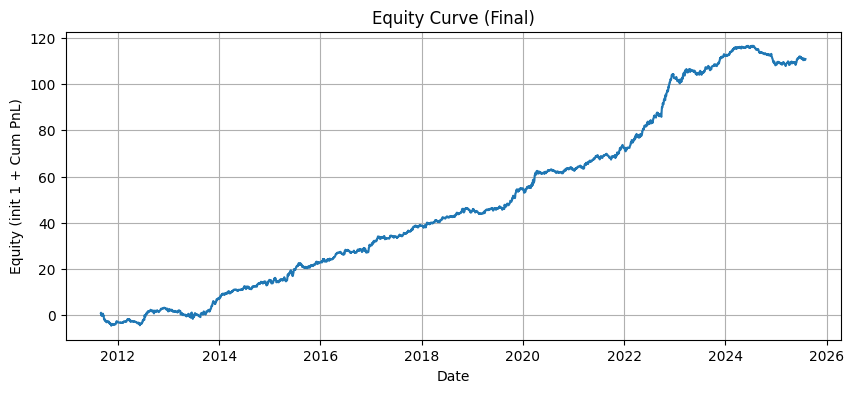

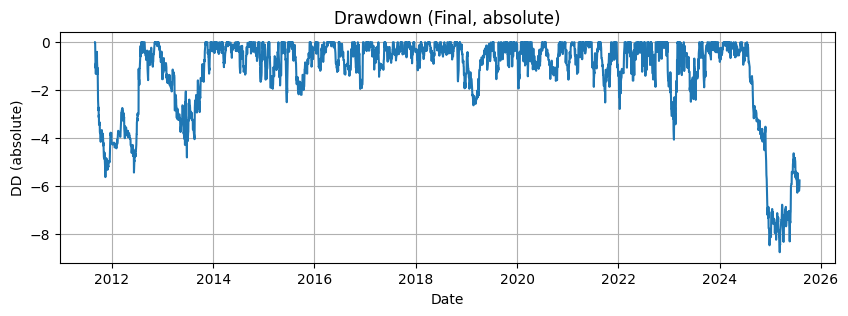

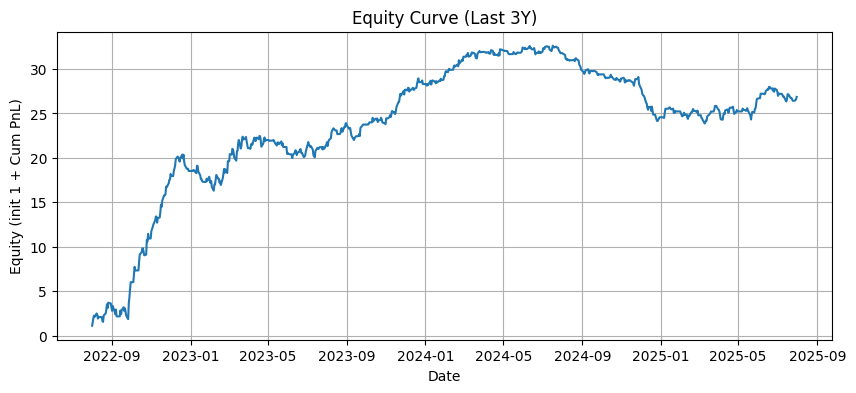

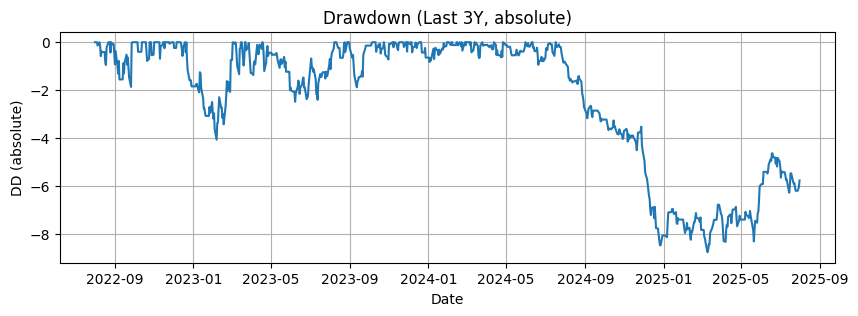

In [14]:
# 4) 성과지표 & 시각화
%matplotlib inline

metrics_all = compute_metrics_from_daily(result)
equity_all  = metrics_all.pop("equity_series")
dd_all      = metrics_all.pop("dd_series")

result_5y = slice_by_years(result, 5)
result_3y = slice_by_years(result, 3)
result_1y = slice_by_years(result, 1)
metrics_5y = compute_metrics_from_daily(result_5y)
metrics_3y = compute_metrics_from_daily(result_3y)
metrics_1y = compute_metrics_from_daily(result_1y)

def fmt_pct(x): return f"{x*100:.2f}%"
def headline_block(m, label="All"):
    print(f"\n=== Headline Metrics ({label}) ===")
    print(f"Total PnL: {m['total_pnl']:.2f}")
    print(f"Trades: {m['total_trades']}")
    print(f"Win Rate: {fmt_pct(m['win_rate'])}")
    print(f"MDD: {m['mdd_abs']:.2f}")
    print(f"Sharpe(ann, approx): {m['sharpe_annual(approx)']:.2f}")
    print(f"CAGR(init=1): {fmt_pct(m['cagr_assuming_init1'])}") # 연평균 수익률
    print(f"Period: {m['period_days']} days ({m['period_years']:.2f} yrs)")

headline_block(metrics_all, "Full")
headline_block(metrics_5y,  "Last 5Y")
headline_block(metrics_3y,  "Last 3Y") 
headline_block(metrics_1y,  "Last 1Y")

table = pd.DataFrame([metrics_all])
display(table[[
    "total_trades","total_pnl","avg_pnl_per_trade","win_rate",
    "sharpe_annual(approx)","mdd_abs","cagr_assuming_init1","period_days","period_years"
]])

# ---- baseline 관련 제거 ----
equity_all.index = result["Date"]
dd_all.index = result["Date"]

plot_equity(equity_all, "Equity Curve (Final)")
plot_drawdown(dd_all, "Drawdown (Final, absolute)")

eq_3y = 1.0 + result_3y["Total_PnL"].cumsum(); eq_3y.index = result_3y["Date"]
dd_3y, _ = compute_drawdown_series(eq_3y); dd_3y.index = result_3y["Date"]
plot_equity(eq_3y, "Equity Curve (Last 3Y)")
plot_drawdown(dd_3y, "Drawdown (Last 3Y, absolute)")


In [ ]:
# 5) 최근 5년/1년 이슈 자동 진단
def diagnose_issues(m):
    issues = []
    if m["win_rate"] < 0.5:
        issues.append("승률이 50% 미만")
    if m["sharpe_annual(approx)"] < 1.0:
        issues.append("연환산 샤프 < 1.0")
    if m["mdd_abs"] < -5:
        issues.append("절대 MDD가 -5 이상")
    if m["cagr_assuming_init1"] < 0:
        issues.append("CAGR 음수")
    return issues or ["특이사항 없음"]

print("최근 5년 이슈:", " / ".join(diagnose_issues(metrics_5y)))
print("최근 1년 이슈:", " / ".join(diagnose_issues(metrics_1y)))


최근 5년 이슈: 절대 MDD가 -5 이상
최근 1년 이슈: 승률이 50% 미만 / 연환산 샤프 < 1.0 / 절대 MDD가 -5 이상 / CAGR 음수


In [ ]:
# (선택) 엑셀로 내보내기: DailyPnL / Baseline / 파라미터
out_path = "mt-usd0920-results.xlsx"
try:
    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        result.to_excel(writer, index=False, sheet_name="DailyPnL")
        # baseline.to_excel(writer, index=False, sheet_name="Baseline")
        meta = pd.DataFrame({
            "Param": ["best_index","rising_rate","falling_rate",
                       "rising_filter_min","rising_filter_max","falling_filter_min","falling_filter_max",
                       "best_buy_sl","best_sell_sl"],
            "Value": [best_index, rising_rate, falling_rate,
                      rising_filter_min, rising_filter_max, falling_filter_min, falling_filter_max,
                      best_buy_sl, best_sell_sl]
        })
        meta.to_excel(writer, index=False, sheet_name="Params")
    print(f"엑셀 저장 완료: {out_path}")
except Exception as e:
    print("엑셀 저장 중 오류:", e)


엑셀 저장 완료: mt-10yr0901-results.xlsx
